In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import random

# Seed and Data Creation
np.random.seed(42)
num_records = 10000
product_ids = np.random.randint(1, 101, num_records)
categories = ['Electronics', 'Apparel', 'Groceries', 'Home & Living', 'Books', 'Beauty & Health']
product_categories = np.random.choice(categories, num_records)
channels = ['Online', 'In-store']
sales_channels = np.random.choice(channels, num_records)
sales_volumes = np.random.randint(1, 101, num_records)
end_date = datetime.now()
start_date = end_date - timedelta(days=365)
date_range = [start_date + timedelta(days=random.randint(0, 365)) for _ in range(num_records)]
sales_dates = sorted(date_range)
sales_data = pd.DataFrame({
    'Product_ID': product_ids,
    'Product_Category': product_categories,
    'Sales_Channel': sales_channels,
    'Sales_Volume': sales_volumes,
    'Sales_Date': sales_dates
})


In [2]:
sales_data['Month_Year'] = sales_data['Sales_Date'].dt.to_period('M')


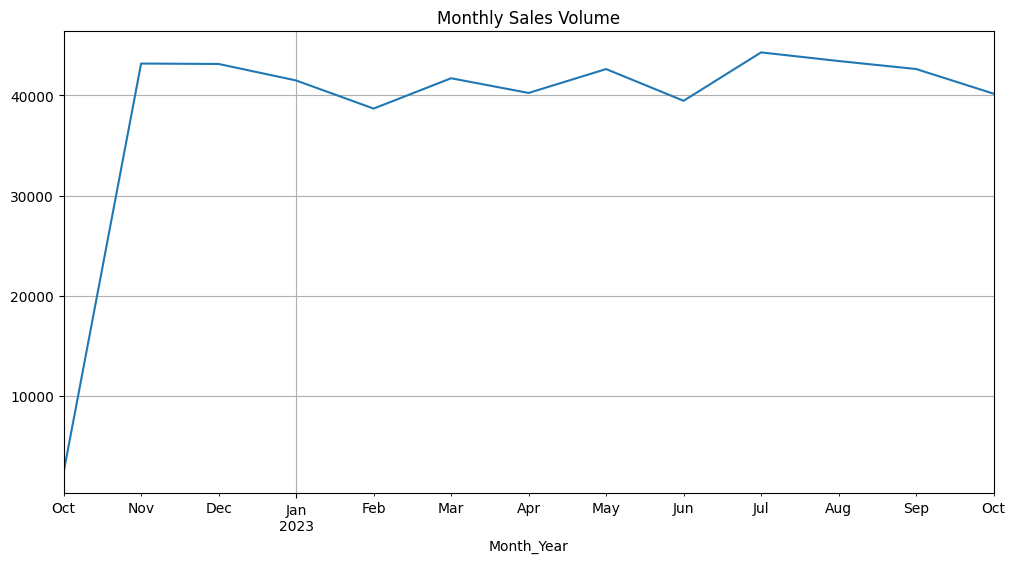

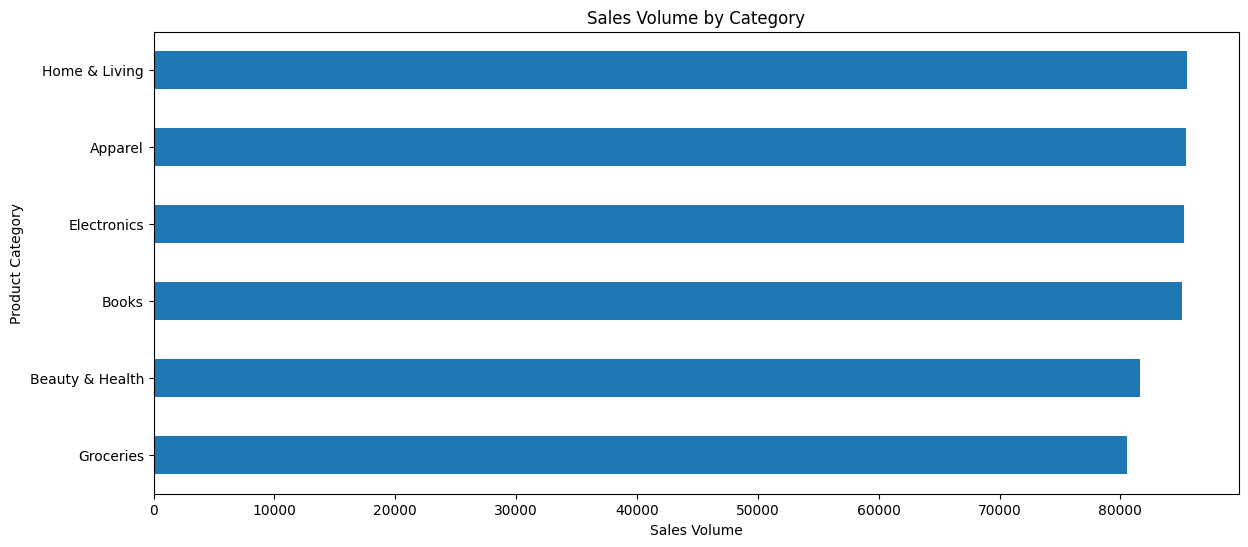

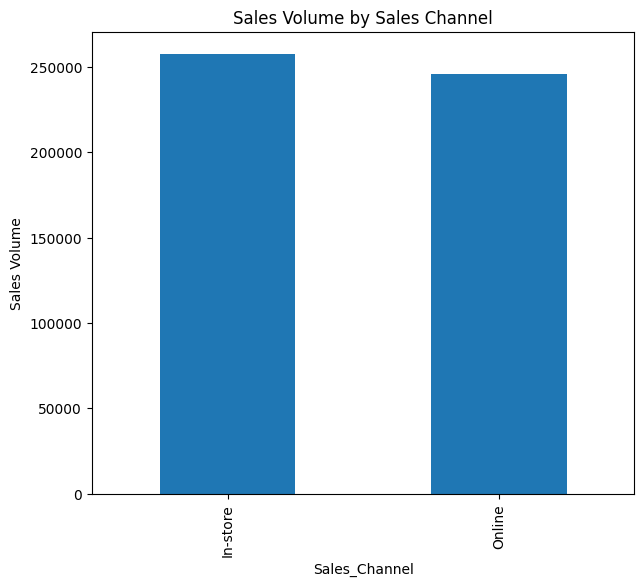

In [4]:
monthly_sales = sales_data.groupby('Month_Year')['Sales_Volume'].sum()
category_sales = sales_data.groupby('Product_Category')['Sales_Volume'].sum()
channel_sales = sales_data.groupby('Sales_Channel')['Sales_Volume'].sum()

plt.figure(figsize=(12, 6))
monthly_sales.plot(title='Monthly Sales Volume')
plt.grid(True)
plt.show()

plt.figure(figsize=(14, 6))
category_sales.sort_values().plot(kind='barh', title='Sales Volume by Category')
plt.xlabel('Sales Volume')
plt.ylabel('Product Category')
plt.show()

plt.figure(figsize=(7, 6))
channel_sales.plot(kind='bar', title='Sales Volume by Sales Channel')
plt.ylabel('Sales Volume')
plt.show()


In [6]:
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Data Preparation for ML
sales_data['Year'] = sales_data['Sales_Date'].dt.year
sales_data['Is_Weekend'] = sales_data['Sales_Date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)
encoded_data = pd.get_dummies(sales_data, columns=['Product_Category', 'Sales_Channel'])
X = encoded_data.drop(columns=['Product_ID', 'Sales_Volume', 'Sales_Date', 'Month_Year'])
y = encoded_data['Sales_Volume']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train a Linear Regression model
lr_model = LinearRegression()
lr_model.fit(X_train, y_train)
y_pred_lr = lr_model.predict(X_test)
rmse_lr = np.sqrt(mean_squared_error(y_test, y_pred_lr))
print(f"RMSE for Linear Regression: {rmse_lr}")


RMSE for Linear Regression: 29.100389512853685


In [10]:
# Adding a future month for prediction
last_date = sales_data['Sales_Date'].max()
future_dates = [last_date + timedelta(days=i) for i in range(1, 31)]

future_data = sales_data.sample(len(future_dates)).reset_index(drop=True)
future_data['Sales_Date'] = future_dates
future_data['Month_Year'] = future_data['Sales_Date'].dt.to_period('M')
future_data['Year'] = future_data['Sales_Date'].dt.year
future_data['Is_Weekend'] = future_data['Sales_Date'].dt.weekday.apply(lambda x: 1 if x >= 5 else 0)

# Encoding the future data
encoded_future_data = pd.get_dummies(future_data, columns=['Product_Category', 'Sales_Channel'])
X_future = encoded_future_data.drop(columns=['Product_ID', 'Sales_Volume', 'Sales_Date', 'Month_Year'])

# Predict sales for the future month
predicted_sales = lr_model.predict(X_future)
future_data['Predicted_Sales'] = predicted_sales

# Top product categories based on predicted sales for the future month
top_predicted_categories = future_data.groupby('Product_Category')['Predicted_Sales'].sum().nlargest(3).index.tolist()

print("Recommend focusing on the following product categories for the next month:", top_predicted_categories)


Recommend focusing on the following product categories for the next month: ['Home & Living', 'Apparel', 'Groceries']


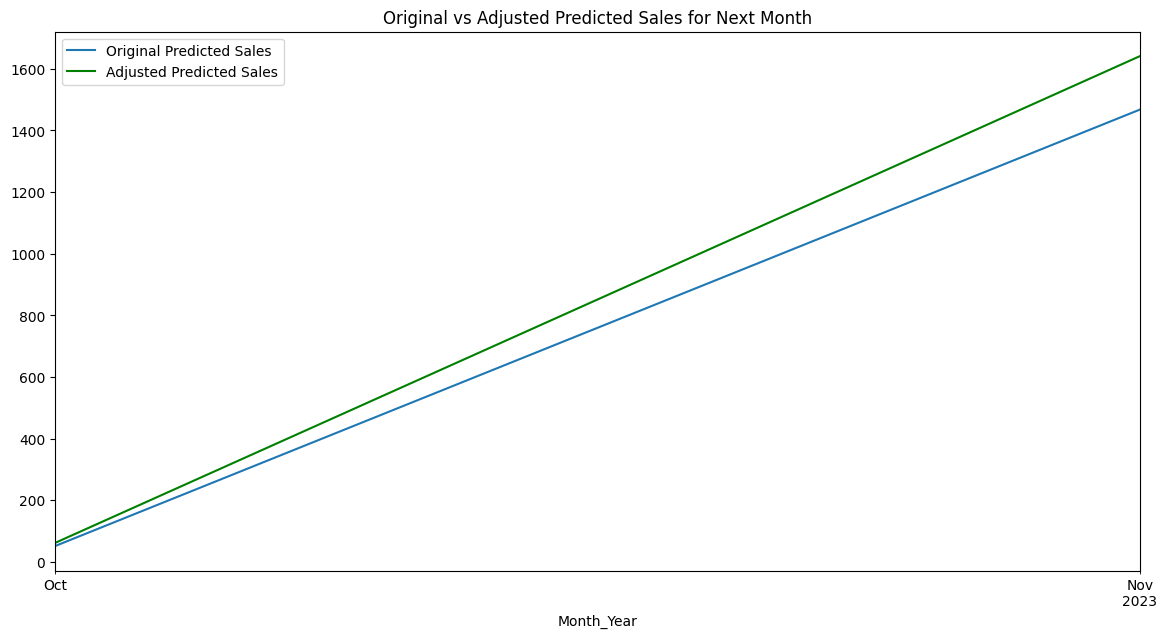

In [11]:
# Simulate a 20% increase in sales for the recommended product categories
future_data['Adjusted_Sales'] = future_data.apply(
    lambda x: x['Predicted_Sales'] * 1.2 if x['Product_Category'] in top_predicted_categories else x['Predicted_Sales'], 
    axis=1)

# Visualize original vs adjusted predicted sales for the next month
plt.figure(figsize=(14, 7))
future_data.groupby('Month_Year')['Predicted_Sales'].sum().plot(label='Original Predicted Sales')
future_data.groupby('Month_Year')['Adjusted_Sales'].sum().plot(label='Adjusted Predicted Sales', color='green')
plt.title('Original vs Adjusted Predicted Sales for Next Month')
plt.legend()
plt.show()
